In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display



def sample_beta_binomial_posteriors(successes, trials, 
                                            alpha_priors=None, beta_priors=None,
                                            samples=100_000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    k = len(successes)
    assert len(trials) == k, "Successes and trials must have the same length"

    if alpha_priors is None:
        alpha_priors = [1] * k
    if beta_priors is None:
        beta_priors = [1] * k

    assert len(alpha_priors) == k and len(beta_priors) == k, "Priors must match number of variants"

    all_samples = []
    for i in range(k):
        alpha_post = alpha_priors[i] + successes[i]
        beta_post = beta_priors[i] + trials[i] - successes[i]
        variant_samples = np.random.beta(alpha_post, beta_post, samples)
        all_samples.append(variant_samples)

    return all_samples  # list of arrays, one per variant


def compute_posterior_stats(samples):
    mean = samples.mean() * 100
    std = samples.std() * 100
    lower, upper = np.percentile(samples, [2.5, 97.5])
    return mean, std, lower * 100, upper * 100

def compute_prob_being_best(samples_list):
    draws = np.vstack(samples_list)  # shape: (num_variants, num_draws)
    winners = np.argmax(draws, axis=0)
    k = len(samples_list)
    return [(winners == i).mean() for i in range(k)]

def summarize_variant_posteriors(samples_list, variant_names=None, reference_idx=None):
    k = len(samples_list)
    if variant_names is None:
        variant_names = [f"Variant {i}" for i in range(k)]

    means = [s.mean() for s in samples_list]
    default_winner_idx = int(np.argmax(means))
    ref_idx = default_winner_idx if reference_idx is None else reference_idx
    ref_samples = samples_list[ref_idx]
    ref_name = variant_names[ref_idx]
    prob_best_list = compute_prob_being_best(samples_list)

    rows = []
    for i, (name, samples) in enumerate(zip(variant_names, samples_list)):
        mean_rate, std, ci_low, ci_high = compute_posterior_stats(samples)
        prob_best = prob_best_list[i]

        if i == ref_idx:
            rows.append({
                "Variant": name,
                "Mean Rate (%)": mean_rate,
                "Std Dev (%)": std,
                "95% CI Lower (%)": ci_low,
                "95% CI Upper (%)": ci_high,
                "P(Best)": f"{prob_best:.2%}",
                "P(Ref better than Variant)": "-",
                "Expected Regret (%)": "-",
                "Avg Uplift vs. Ref (%)": "-",
                "P(Better than Ref)": "-"
            })
        else:
            prob_better = (samples > ref_samples).mean()
            uplift = (samples / ref_samples - 1) * 100
            regret = np.abs(samples - ref_samples) * 100

            rows.append({
                "Variant": name,
                "Mean Rate (%)": mean_rate,
                "Std Dev (%)": std,
                "95% CI Lower (%)": ci_low,
                "95% CI Upper (%)": ci_high,
                "P(Best)": f"{prob_best:.2%}",
                "P(Ref better than Variant)": f"{(1 - prob_better):.2%}",
                "Expected Regret (%)": regret.mean(),
                "Avg Uplift vs. Ref (%)": uplift.mean(),
                "P(Better than Ref)": f"{prob_better:.2%}"
            })

    df = pd.DataFrame(rows)
    return df.sort_values("Mean Rate (%)", ascending=False).reset_index(drop=True)[[
        "Variant",
        "Mean Rate (%)",
        "Std Dev (%)",
        "95% CI Lower (%)",
        "95% CI Upper (%)",
        "P(Best)",
        "P(Ref better than Variant)",
        "Expected Regret (%)",
        "Avg Uplift vs. Ref (%)",
        "P(Better than Ref)"
    ]]






def plot_variant_posteriors(samples_list, variant_names=None):
    """
    Plots posterior histograms of conversion rates for all variants.
    """
    if variant_names is None:
        variant_names = [f"Variant {i}" for i in range(len(samples_list))]

    plt.figure(figsize=(10, 5))
    for samples, name in zip(samples_list, variant_names):
        plt.hist(samples, bins=100, alpha=0.5, label=name)
    plt.title("Posterior Distributions of Conversion Rates")
    plt.legend()
    plt.show()


def compare_variant_posteriors(samples_list, variant_names=None):
    """
    Wrapper to plot and summarize posterior comparisons between multiple variants.
    """
    plot_variant_posteriors(samples_list, variant_names)
    df = summarize_variant_posteriors(samples_list, variant_names)
    display(df)



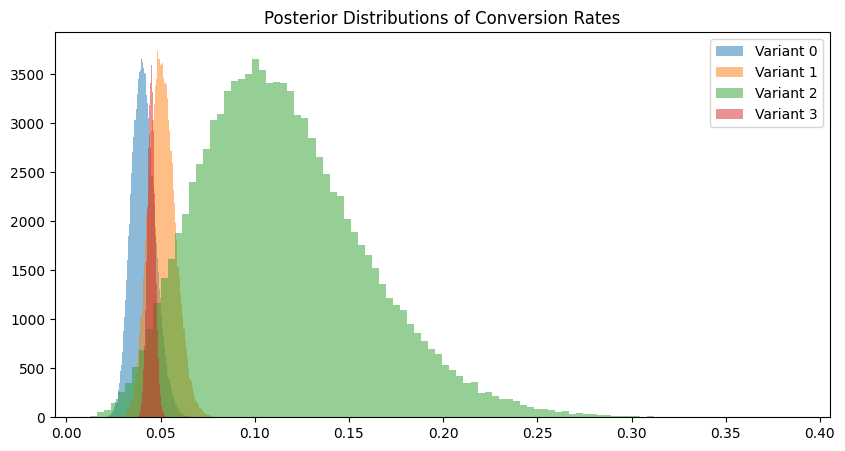

,Variant,Mean Rate (%),Std Dev (%),95% CI Lower (%),95% CI Upper (%),P(Best),P(Ref better than Variant),Expected Regret (%),Avg Uplift vs. Ref (%),P(Better than Ref)
0,Variant 2,11.551786,4.400653,4.429505,21.457807,94.84%,-,-,-,-
1,Variant 1,5.090440,0.696709,3.818486,6.535495,4.20%,95.15%,6.564404,-48.098338,4.85%
2,Variant 3,4.509743,0.207136,4.113042,4.924487,0.54%,97.28%,7.0878,-54.020085,2.71%
3,Variant 0,4.091798,0.624591,2.960618,5.400759,0.43%,97.93%,7.493961,-58.28049,2.07%


In [2]:
samples = sample_beta_binomial_posteriors([40,50,5,450],[1000,1000,50,10000])
compare_variant_posteriors(samples)


In [3]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

def frequentist_ab_test(success_a, trials_a, success_b, trials_b):
    """
    Performs a two-proportion z-test for A/B testing.

    Returns:
        p_value: The p-value for the test
        z_stat: The z-statistic (optional for interpretation)
    """
    count = np.array([success_a, success_b])
    nobs = np.array([trials_a, trials_b])
    z_stat, p_value = proportions_ztest(count, nobs)
    return z_stat, p_value


In [50]:
# Define the function to simulate results over a grid of sample sizes and uplifts
def run_ab_test_grid(sample_sizes, uplifts, baseline_rate=0.04):
    results = []

    for n in sample_sizes:
        for uplift in uplifts:
            # Simulate success counts
            p_a = baseline_rate
            p_b = baseline_rate + uplift
            successes_a = int(p_a * n)
            successes_b = int(p_b * n)

            # Run frequentist test
            z_stat, p_value = frequentist_ab_test(successes_a, n, successes_b, n)

            # Run Bayesian posterior sampling
            samples_a, samples_b = sample_beta_binomial_posteriors(
                [successes_a, successes_b], [n, n], samples=1_000_000, seed=42
            )

            # Compute Bayesian probability
            prob_b_better = (samples_b > samples_a).mean()

            results.append({
                'Sample Size': n,
                'Uplift (%)': uplift * 100,
                'Conversion B (%)': p_b * 100,
                'Frequentist p-value': round(p_value, 6),
                'Bayesian P(B > A)': round(prob_b_better, 6)
            })

    return pd.DataFrame(results)

# Define input arrays
sample_sizes_test = [100, 500, 1000, 5000, 10000, 50000]
uplifts_test = np.round(np.arange(0.001, 0.031, 0.001), 3)

# Run the grid evaluation
ab_test_results = run_ab_test_grid(sample_sizes_test, uplifts_test)

# Display the result
ab_test_results

,Sample Size,Uplift (%),Conversion B (%),Frequentist p-value,Bayesian P(B > A)
0,100,0.1,4.1,1.0,0.499784
1,100,0.2,4.2,1.0,0.499784
2,100,0.3,4.3,1.0,0.499784
3,100,0.4,4.4,1.0,0.499784
4,100,0.5,4.5,1.0,0.499784
...,...,...,...,...,...
175,50000,2.6,6.6,0.0,1.000000
176,50000,2.7,6.7,0.0,1.000000
177,50000,2.8,6.8,0.0,1.000000
178,50000,2.9,6.9,0.0,1.000000


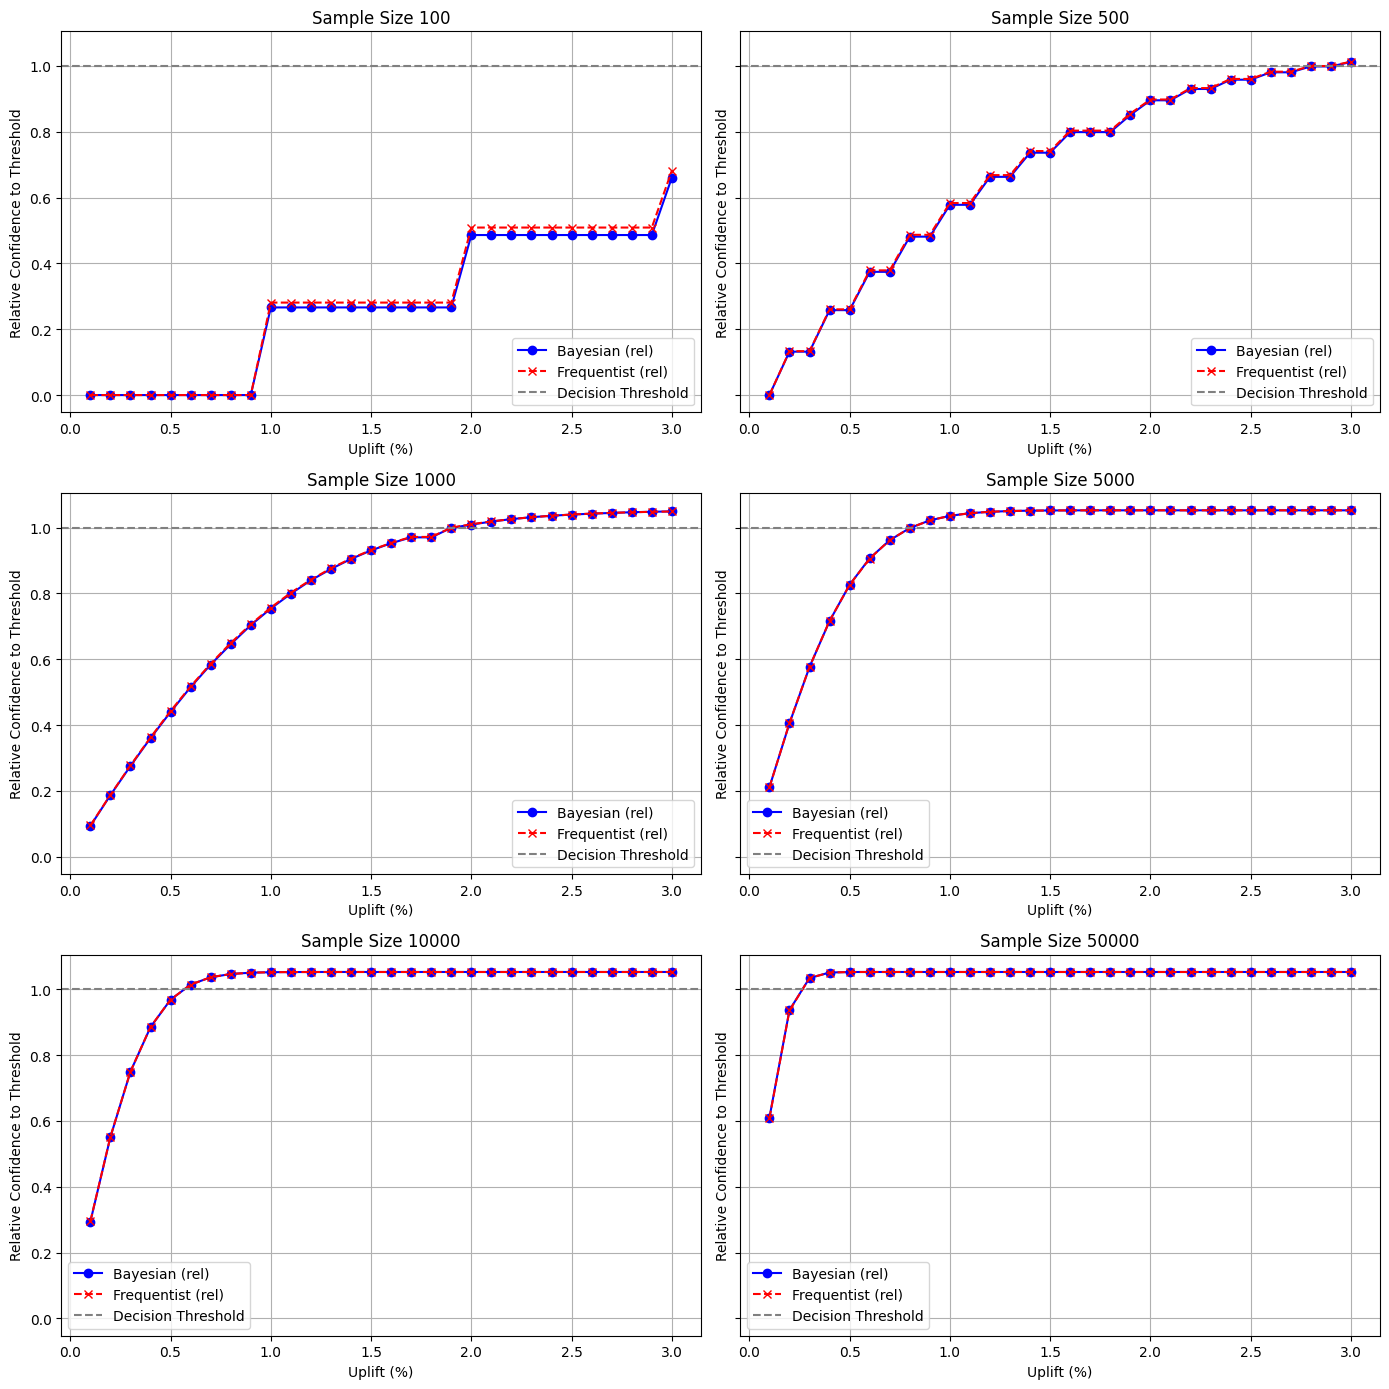

In [51]:
def plot_all_sample_sizes_overlay_relative(df, sample_sizes, target_bayes=0.975):
    """
    Plots Bayesian and frequentist confidence relative to their decision thresholds.
    Values are normalized such that 1.0 means 'crossed decision threshold'.

    Parameters:
    - df: DataFrame with test results
    - sample_sizes: list of sample sizes to plot
    - target_bayes: the Bayesian confidence threshold to treat as 'decision line' (e.g., 0.975 or 0.99)
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharey=True)
    axes = axes.flatten()

    for idx, size in enumerate(sample_sizes):
        subset = df[df['Sample Size'] == size].copy()

        # Normalize both curves so that 1 = decision threshold
        subset['Relative Bayesian'] = (subset['Bayesian P(B > A)'] - 0.5) / (target_bayes - 0.5)
        subset['Relative Bayesian'] = subset['Relative Bayesian'].clip(0, 1.1)

        subset['Relative Frequentist'] = (1 - subset['Frequentist p-value']) / 0.95
        subset['Relative Frequentist'] = subset['Relative Frequentist'].clip(0, 1.1)

        ax = axes[idx]
        ax.plot(subset['Uplift (%)'], subset['Relative Bayesian'], marker='o', label='Bayesian (rel)', color='blue')
        ax.plot(subset['Uplift (%)'], subset['Relative Frequentist'], marker='x', linestyle='--', label='Frequentist (rel)', color='red')
        ax.axhline(1.0, color='gray', linestyle='--', label='Decision Threshold')
        ax.set_title(f"Sample Size {size}")
        ax.set_xlabel("Uplift (%)")
        ax.set_ylabel("Relative Confidence to Threshold")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_sample_sizes_overlay_relative(ab_test_results, sample_sizes_test, target_bayes=0.975)


In [70]:
import numpy as np
import pandas as pd

from statsmodels.stats.proportion import proportions_ztest

def compute_cv(true_p_a=0.05, true_p_b=0.06, sample_size=1000, draw_size=10000,
               repetitions=500, prior_alpha=1, prior_beta=1, seed=42):
    np.random.seed(seed)

    # Frequentist: use z-statistic variability instead of p-value CV
    freq_stats = []
    for _ in range(repetitions):
        successes_a = np.random.binomial(sample_size, true_p_a)
        successes_b = np.random.binomial(sample_size, true_p_b)

        count = np.array([successes_a, successes_b])
        nobs = np.array([sample_size, sample_size])
        try:
            stat, _ = proportions_ztest(count, nobs)
        except:
            stat = np.nan
        freq_stats.append(stat)

    freq_stats = np.array(freq_stats)
    freq_mean = np.nanmean(freq_stats)
    freq_cv = np.nan if abs(freq_mean) < 1e-6 else np.nanstd(freq_stats) / abs(freq_mean)

    # Bayesian CV on P(B > A)
    bayes_probs = []
    for _ in range(repetitions):
        successes_a = np.random.binomial(sample_size, true_p_a)
        successes_b = np.random.binomial(sample_size, true_p_b)

        samples_a = np.random.beta(successes_a + prior_alpha, sample_size - successes_a + prior_beta, size=draw_size)
        samples_b = np.random.beta(successes_b + prior_alpha, sample_size - successes_b + prior_beta, size=draw_size)
        p_b_better = (samples_b > samples_a).mean()
        bayes_probs.append(p_b_better)

    bayes_probs = np.array(bayes_probs)
    bayes_mean = np.nanmean(bayes_probs)
    bayes_cv = np.nan if bayes_mean < 1e-4 else np.nanstd(bayes_probs) / bayes_mean

    return freq_cv, bayes_cv

def run_cv_matrix(sample_sizes, draw_sizes, **kwargs):
    freq_matrix = pd.DataFrame(index=sample_sizes, columns=draw_sizes)
    bayes_matrix = pd.DataFrame(index=sample_sizes, columns=draw_sizes)

    for n in sample_sizes:
        for d in draw_sizes:
            freq_cv, bayes_cv = compute_cv(sample_size=n, draw_size=d, **kwargs)
            freq_matrix.loc[n, d] = freq_cv
            bayes_matrix.loc[n, d] = bayes_cv

    return freq_matrix.astype(float), bayes_matrix.astype(float)


In [78]:
sample_sizes = [100, 200, 300, 400, 500, 750, 1000,5000,10_000, 15_000, 20_000, 25_000, 50_000,100_000,500_000, 1_000_000]
draw_sizes = [10,100,1000,10_000, 50_000, 100_000]

freq_cv, bayes_cv = run_cv_matrix(sample_sizes, draw_sizes)

In [76]:
def plot_cv_matrices(freq_cv_matrix, bayes_cv_matrix):
    draw_sizes = freq_cv_matrix.columns
    sample_sizes = freq_cv_matrix.index

    fig, axes = plt.subplots(nrows=(len(draw_sizes) + 1) // 2, ncols=2, figsize=(14, 14), sharey=True)
    axes = axes.flatten()

    for idx, draw_size in enumerate(draw_sizes):
        ax = axes[idx]
        ax.plot(sample_sizes, bayes_cv_matrix[draw_size], marker='o', label='Bayesian CV', color='blue')
        ax.plot(sample_sizes, freq_cv_matrix[draw_size], marker='x', linestyle='--', label='Frequentist CV', color='red')
        ax.set_title(f"Draw Size {draw_size}")
        ax.set_xlabel("Sample Size")
        ax.set_ylabel("Coefficient of Variation")
        ax.grid(True)
        ax.legend()

    for idx in range(len(draw_sizes), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

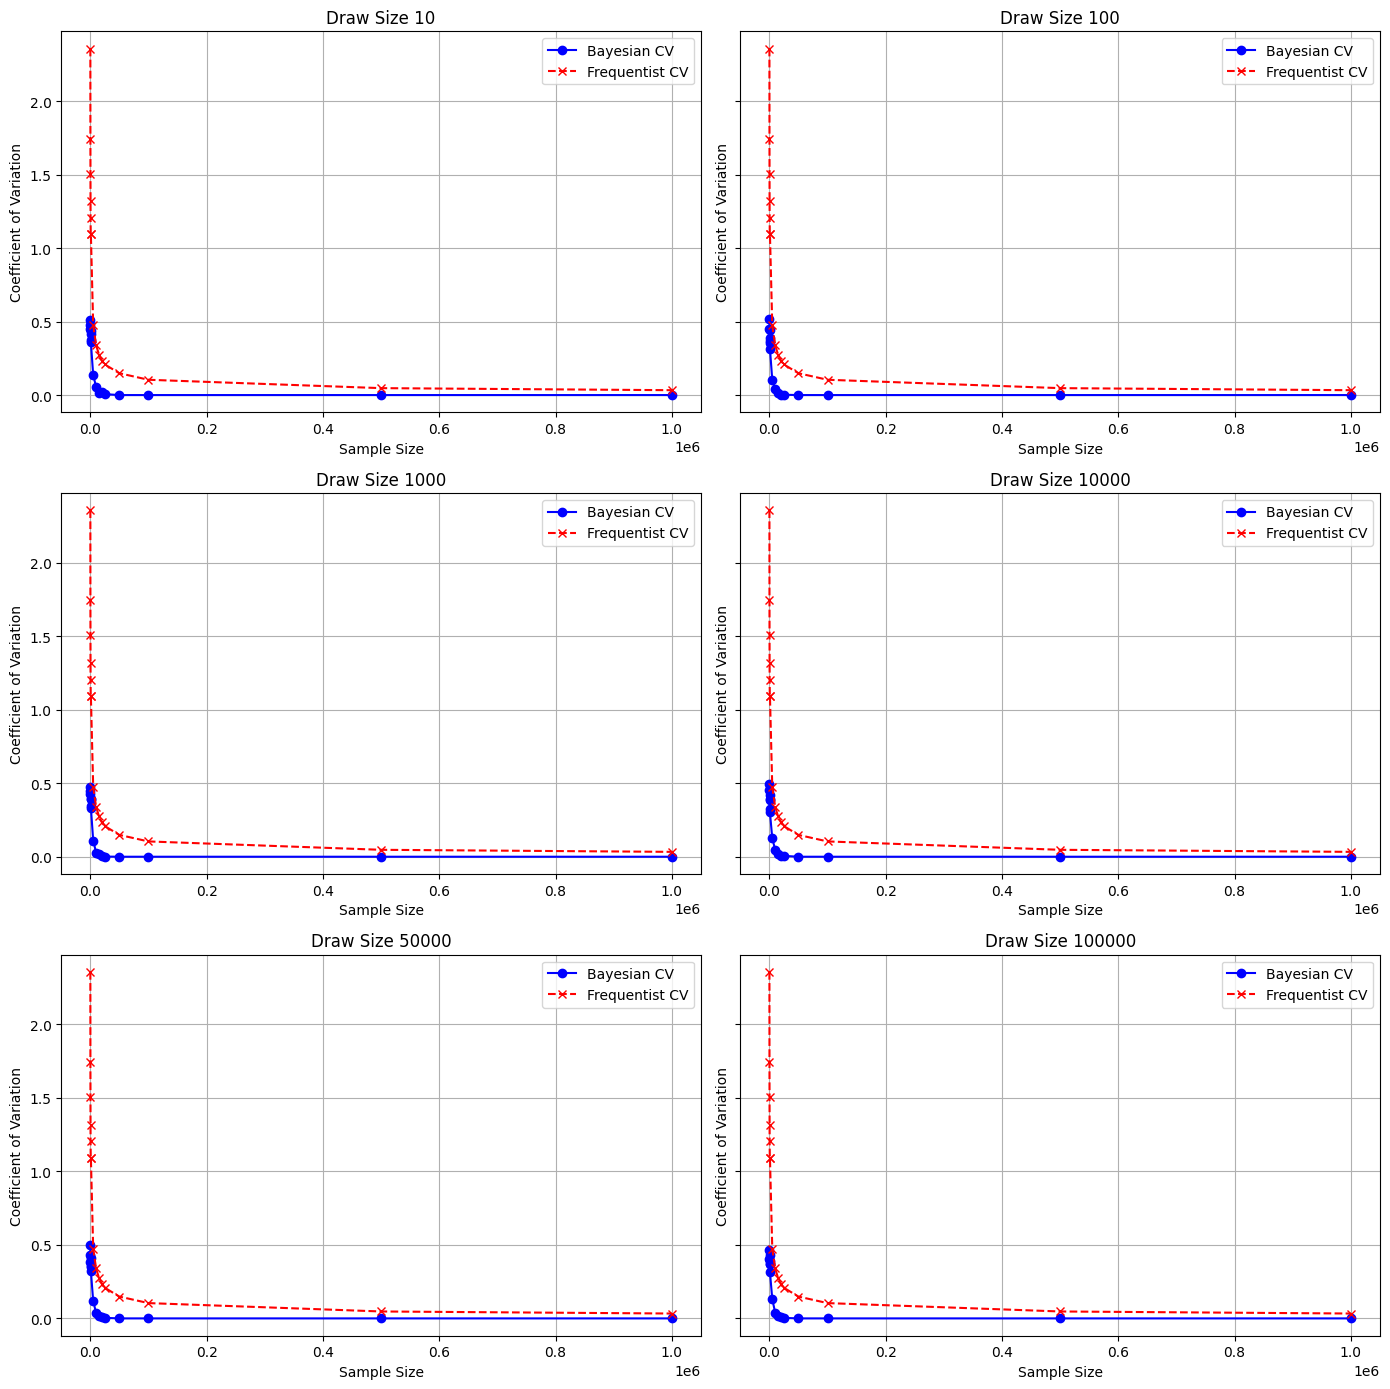

In [79]:
plot_cv_matrices(freq_cv, bayes_cv)

In [96]:
def bayesian_power_binary_search(baseline_rate, uplift, alpha_prior=1, beta_prior=1,
                                  required_probability=0.975, max_sample_size=100000,
                                  draws=100_000, seed=42, min_step=100):
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Initialize search bounds
    low = 1
    high = max_sample_size
    best_sample_size = None  # Stores the best (minimum sufficient) sample size found

    while low <= high:
        # Print the current interval being searched
        print(low, high)
        
        # Take the midpoint of the current search interval
        mid = (low + high) // 2

        # Compute simulated successes for both variants using the midpoint sample size
        successes_a = int(mid * baseline_rate)
        successes_b = int(mid * (baseline_rate + uplift))

        # Sample posterior distributions from Beta for A and B using 'mid' trials
        # → This simulates running a Bayesian A/B test with sample size = mid
        samples_list = sample_beta_binomial_posteriors(
            successes=[successes_a, successes_b],
            trials=[mid, mid],
            alpha_priors=[alpha_prior, alpha_prior],
            beta_priors=[beta_prior, beta_prior],
            samples=draws,
            seed=seed
        )

        # Calculate how often B is better than A in the sampled posteriors
        prob_b_better = (samples_list[1] > samples_list[0]).mean()

        # If the result meets the required probability, record this mid as the current best
        if prob_b_better >= required_probability:
            best_sample_size = mid
            high = mid - 1  # Search for a smaller valid sample size
        else:
            low = mid + 1   # Not enough confidence, try larger sample sizes

        # Stop when the interval is smaller than the desired resolution
        if high - low < min_step:
            break

    # Return the smallest sample size that gave required confidence
    return best_sample_size


# Example usage
needed_sample_size_binary = bayesian_power_binary_search(baseline_rate=0.05, uplift=0.01)
needed_sample_size_binary


1 100000
1 49999
1 24999
1 12499
1 6249
3126 6249
3126 4686
3907 4686
3907 4295
3907 4100


4101